In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

In [6]:
df = pd.read_csv('data/AmesHousing.csv')


In [7]:
df = df[(df['Lot Frontage'] <= 150) & (df['Lot Area'] <= 20000)]
X = df[['Lot Frontage', 'Lot Area']]
y = df['SalePrice']

In [8]:
df_sample = df[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15,
    random_state=42,
    ignore_index=True
)

In [9]:
model = tree.DecisionTreeRegressor(max_depth=3)
model.fit(X, y)


DecisionTreeRegressor(max_depth=3)

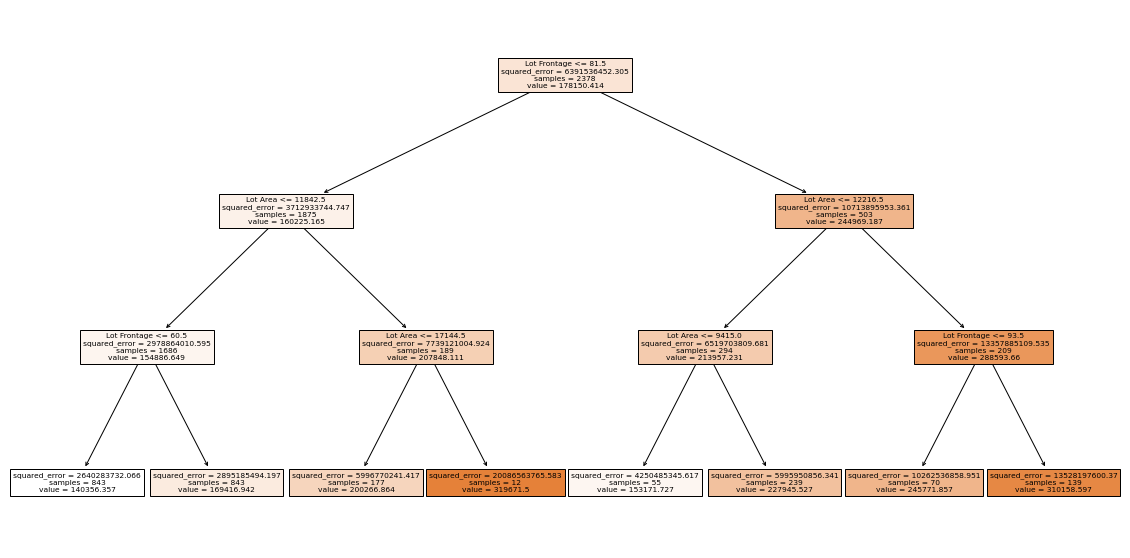

In [10]:
fig = plt.figure(figsize=(20, 10))
tree_graf = tree.plot_tree(
    model,
    feature_names=X.columns,
    filled=True,
    impurity=True
)

/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


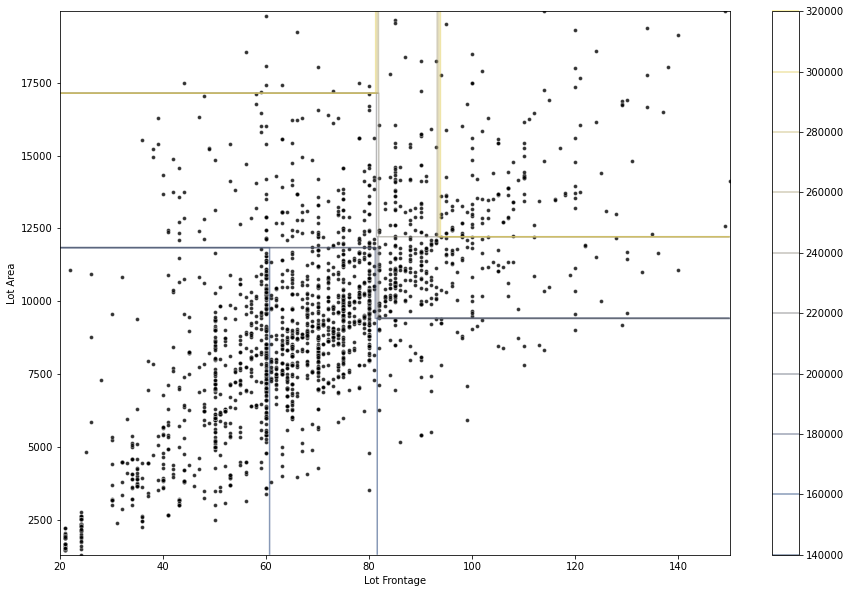

In [11]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1, 1),
        np.arange(X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1, 1),
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])

    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contour(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)
    
fig = plt.figure(figsize=(15, 10))
plot_decision_bound_regression(X, y, model, fig)

In [12]:
bill_data = pd.read_csv('data/bill_authentication.csv')
X = bill_data[['Variance', 'Skewness']]
y = bill_data['Class']

In [13]:
model2 = tree.DecisionTreeClassifier(max_depth=4)
model2.fit(X, y)

DecisionTreeClassifier(max_depth=4)

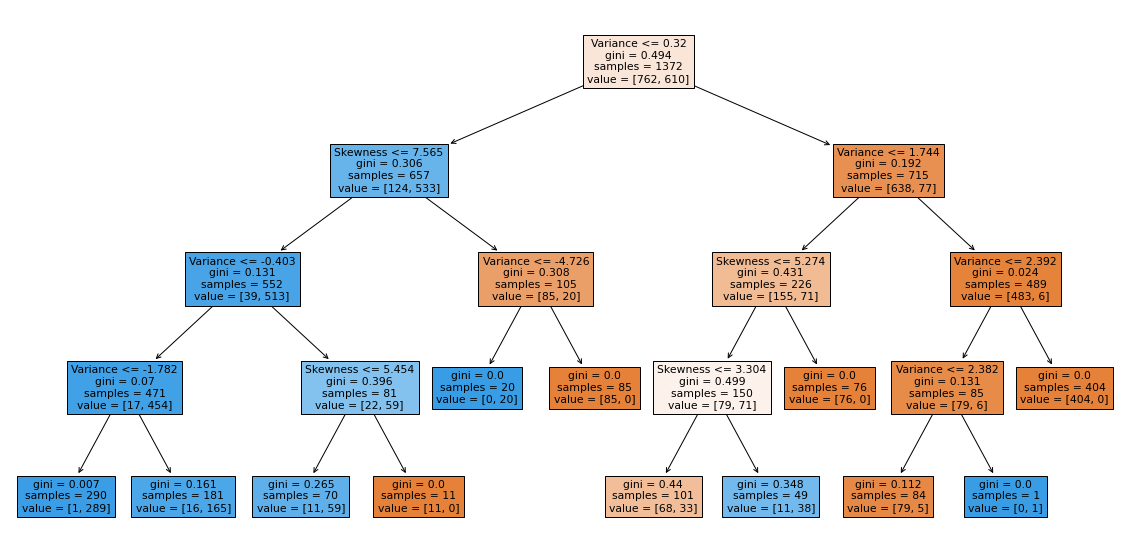

In [14]:
fig = plt.figure(figsize=(20, 10))
tree_graf = tree.plot_tree(
    model2,
    feature_names=X.columns,
    filled=True,
    impurity=True
)

/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


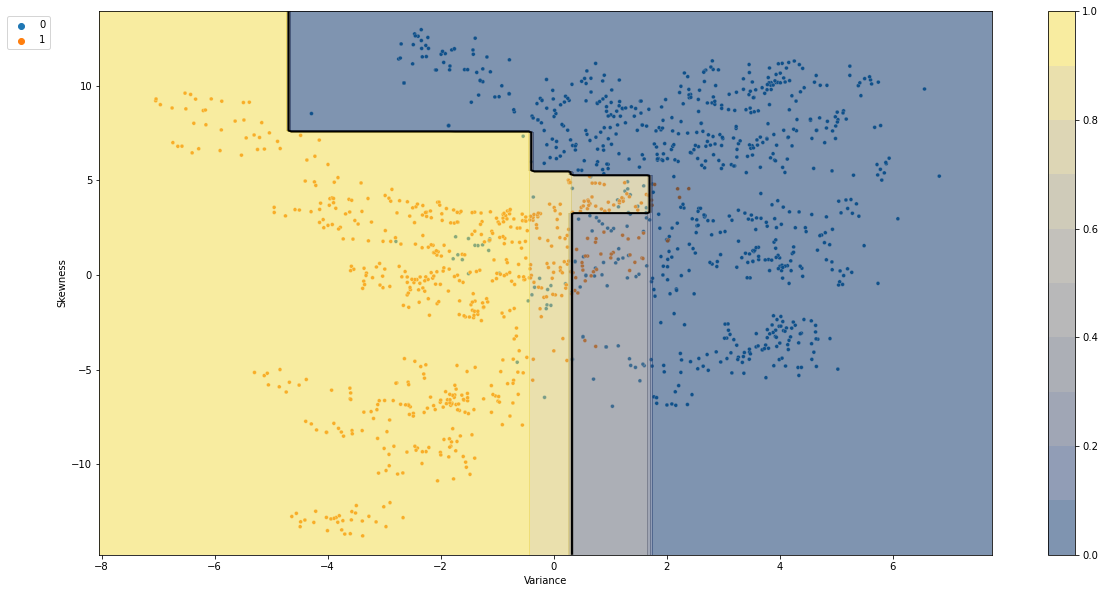

In [15]:
def plot_decision_bound_classification(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, s=15, alpha=1)
    contour = plt.contourf(xx1, xx2, probs, 10, cmap='cividis', alpha=0.5)
    bound = plt.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    fig.colorbar(contour)
    plt.legend(bbox_to_anchor=(-0.05, 1))
    
fig = plt.figure(figsize=(20, 10))
plot_decision_bound_classification(X, y, model2, fig)

In [16]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
x = data['age']
y = data['loan']

In [17]:
def find_candidates_for_thresholds(X, y):
    X = X.sort_values().drop_duplicates()
    x_rol_mean = X.rolling(2).mean().dropna()
    y = y[x_rol_mean.index]
    y_rol_mean = y.diff()
    candidates = x_rol_mean[y_rol_mean != 0]
    return candidates.values

print(find_candidates_for_thresholds(data['age'], data['loan']))
print(find_candidates_for_thresholds(data['income'], data['loan']))

[17.5 19.  22.5 30.  34.5 43.5]
[23.5 34.5 36.5 48.  64.5 72. ]


In [18]:
print(find_candidates_for_thresholds(df_sample['Lot Frontage'], df_sample['SalePrice']))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]


In [19]:
print(find_candidates_for_thresholds(df_sample['Lot Area'], df_sample['SalePrice']))

[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]


In [20]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred)**2).mean()

In [21]:
def split(X, y, split_params):
    #print(split_params)
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    
    return X_left, y_left, X_right, y_right

In [22]:
def calculate_weighted_impurity(X, y, split_params, criteriation):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right = y.size, y_left.size, y_right.size
    score = N_left/N * criteriation(y_left) + N_right/N * criteriation(y_right)
    
    return score
    

In [23]:
def best_split(X, y, criteriation):
    M = X.shape[1]
    min_weight_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weight_impurity = calculate_weighted_impurity(X, y, split_params, criteriation)
            if weight_impurity < min_weight_impurity:
                min_weight_impurity = weight_impurity
                optimal_split_params = split_params
    return optimal_split_params

In [24]:
data = pd.DataFrame({
    'x1': list(range(1, 16)),
    'y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 3]
})
X = data[['x1']]
y = data['y']

In [25]:
optimal_params = best_split(X, y, criteriation=squared_error)
print('Optimal j: ', optimal_params[0])
print('Optimal t: ', optimal_params[1])

Optimal j:  0
Optimal t:  5.5


[Text(0.5, 0.75, 'x1 <= 5.5\nsquared_error = 4.686\nsamples = 15\nvalue = 3.647'),
 Text(0.25, 0.25, 'squared_error = 0.022\nsamples = 5\nvalue = 1.14'),
 Text(0.75, 0.25, 'squared_error = 2.306\nsamples = 10\nvalue = 4.9')]

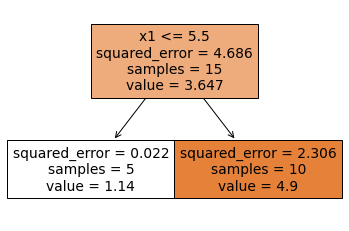

In [26]:
dt  = tree.DecisionTreeRegressor(
    max_depth=1,
    criterion='squared_error',
    random_state=0
)

dt.fit(X, y)

tree.plot_tree(
    dt,
    feature_names=X.columns,
    filled=True,
    impurity=True
)

In [27]:
ames_sample = df[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаем обучающую выборку
X = ames_sample[['Lot Frontage', 'Lot Area']]
y = ames_sample['SalePrice']

In [28]:
best_split(X, y, criteriation=squared_error)

(0, 71.0)

In [29]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

In [30]:
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [31]:
optimal_params = best_split(X, y, criteriation=entropy)
print('Optimal j: ', optimal_params[0])
print('Optimal t: ', optimal_params[1])

Optimal j:  1
Optimal t:  3.22085


**Постороение дерева решений**

In [32]:
class Node:
    def __init__(self, left = None, right = None, value = None, split_params = None, impurity = None, samples = None, is_leaf = False) -> None:
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

In [33]:
def create_leaf_prediction(y):
    return y.mode()[0]

def stopping_criterion(X, y, criterion, max_depth = None, depth = 0):
    if max_depth == None:
        return criterion(y) == 0
    else:
        return criterion(y) == 0 or depth > max_depth

In [34]:
def build_decision_tree(X, y, criterion, max_depth = None, depth = 0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value,
            impurity=criterion(y),
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criteriation=entropy)
        X_left, y_left, X_right, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_right, y_right, criterion, max_depth, depth)
        node = Node(
            left=left,
            right=right,
            split_params=split_params,
            impurity=criterion(y),
            samples=y.size
        )
    
    return node

In [35]:
def print_decision_tree(node, depth = 0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: ', node.value)
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)

In [36]:
# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 

decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class:  1
             feature_0 > 19.000:
                class:  0
          feature_0 > 22.500:
             class:  1
       feature_1 > 86.000:
          class:  0
    feature_0 > 43.500:
       class:  0


In [37]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=1000
)
dt.fit(X, y)

print(tree.export_text(decision_tree=dt))

|--- feature_0 <= 43.50
|   |--- feature_1 <= 86.00
|   |   |--- feature_0 <= 22.50
|   |   |   |--- feature_0 <= 19.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  19.00
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  22.50
|   |   |   |--- class: 1
|   |--- feature_1 >  86.00
|   |   |--- class: 0
|--- feature_0 >  43.50
|   |--- class: 0



In [38]:
def predict_sample(node, X):
    if node.is_leaf:
        return node.value
    
    j, t = node.split_params
    if X[j] <= t:
        return predict_sample(node.left, X)
    else:
        return predict_sample(node.right, X)
        

In [39]:
def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

In [40]:
y_pred = predict(decision_tree, X)
print(y_pred)

[1 0 1 0 1 0 0 1 1 0]


In [41]:
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [42]:
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class:  0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class:  1
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class:  0
                feature_0 > 0.988:
                   class:  1
       feature_0 > 2.756:
          class:  0
    feature_1 > 3.221:
       class:  0


In [43]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 40],
    'y': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]
})
# Создаём обучающую выборку
X = data[['age', 'income']]
y = data['y']

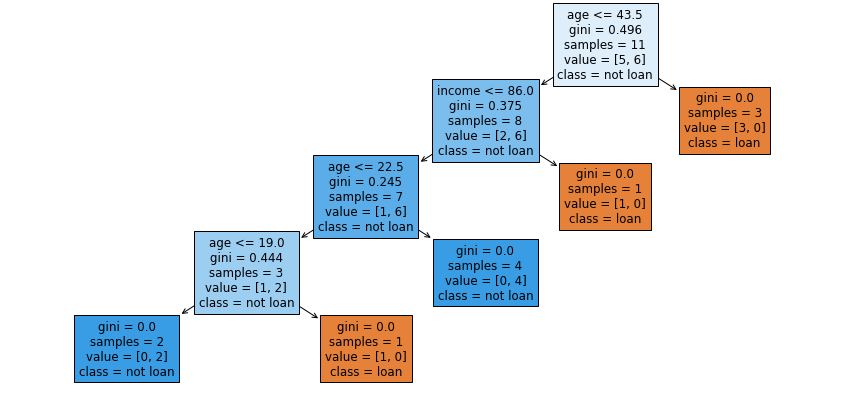

In [44]:
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graf = tree.plot_tree(
    decision_tree=dt,
    feature_names=X.columns,
    class_names=['loan', 'not loan'],
    filled=True,
    impurity=True
)

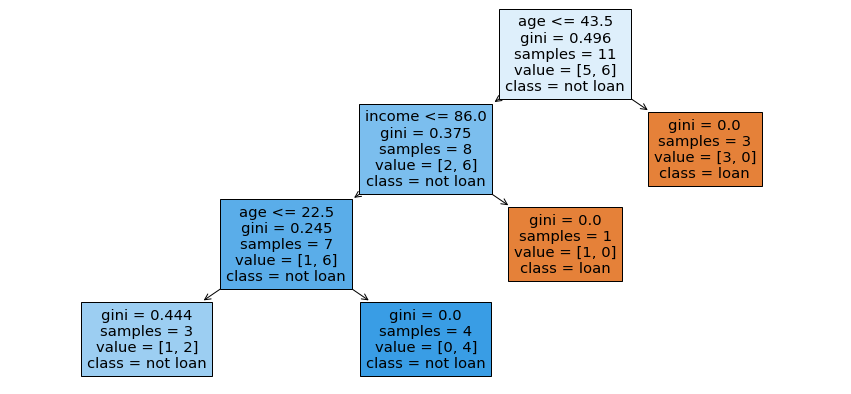

In [45]:
dt = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graf = tree.plot_tree(
    decision_tree=dt,
    feature_names=X.columns,
    class_names=['loan', 'not loan'],
    filled=True,
    impurity=True
)

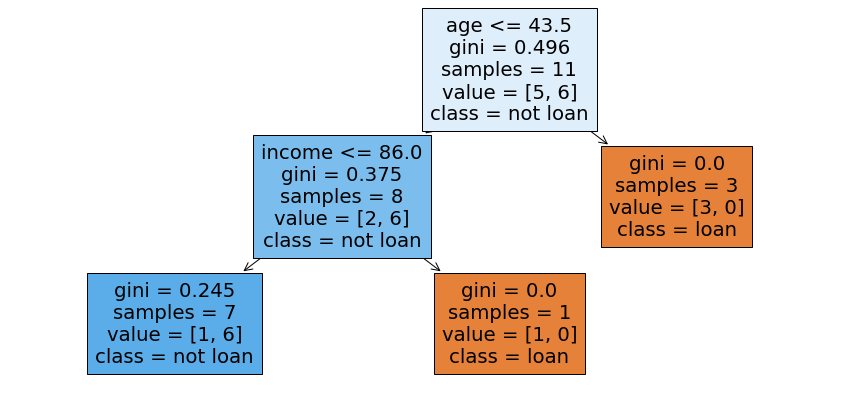

In [46]:
dt = tree.DecisionTreeClassifier(random_state=42, max_leaf_nodes=3)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graf = tree.plot_tree(
    decision_tree=dt,
    feature_names=X.columns,
    class_names=['loan', 'not loan'],
    filled=True,
    impurity=True
)

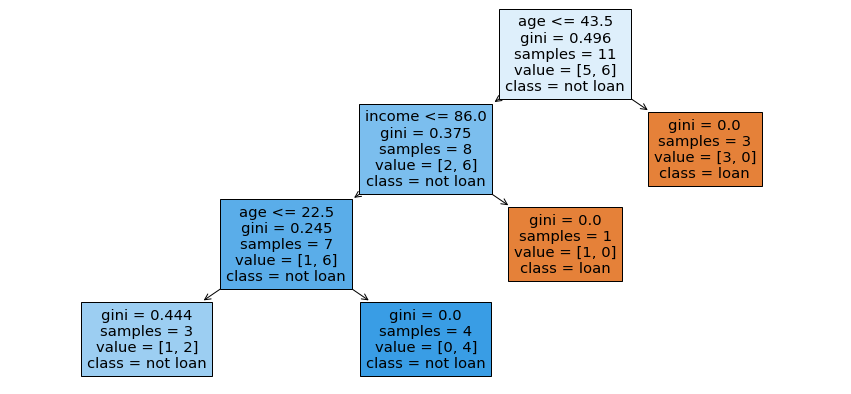

In [47]:
dt = tree.DecisionTreeClassifier(random_state=42, min_samples_split=6)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graf = tree.plot_tree(
    decision_tree=dt,
    feature_names=X.columns,
    class_names=['loan', 'not loan'],
    filled=True,
    impurity=True
)

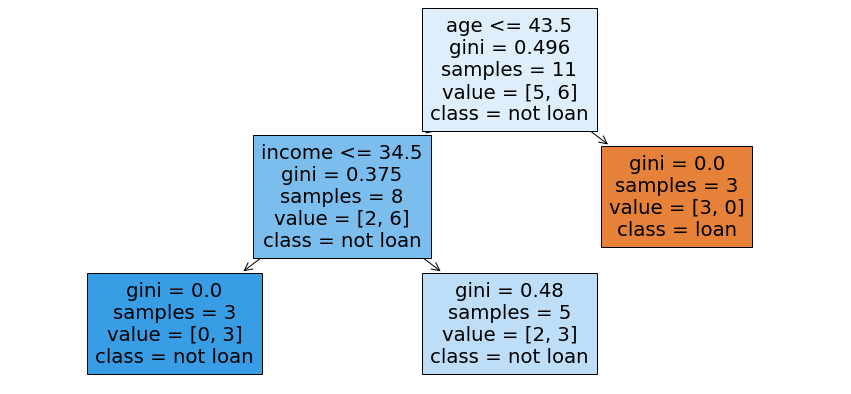

In [48]:
dt = tree.DecisionTreeClassifier(random_state=42, min_samples_leaf=3)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graf = tree.plot_tree(
    decision_tree=dt,
    feature_names=X.columns,
    class_names=['loan', 'not loan'],
    filled=True,
    impurity=True
)

In [49]:
# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 

decision_tree = build_decision_tree(X, y, criterion=entropy, max_depth=2)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          class:  1
       feature_1 > 86.000:
          class:  0
    feature_0 > 43.500:
       class:  0


In [50]:
def calculate_feature_importance(node, feature_importance = None):
    if feature_importance is None:
        feature_importance = np.zeros(X.shape[1])
    if not node.is_leaf:
        j = node.split_params[0]
        feature_importance[j] += node.impurity*node.samples - node.left.impurity*node.left.samples - node.right.impurity*node.right.samples
        calculate_feature_importance(node.left, feature_importance)
        calculate_feature_importance(node.right, feature_importance)
        
    feature_importance /= node.samples
    feature_importance /= feature_importance.sum()
    
    return feature_importance
        

In [51]:
# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, entropy)
# Вычисляем значения информативности признаков
print(calculate_feature_importance(decision_tree))

[0.78582905 0.21417095]
